# Часть 1: Алоха, Компьютерное Зрение!

## 1.1. Вступление: "Что за зверь этот CV?"

Всем привет! Сегодня у нас с вами очень интересная и, я бы сказал, *магическая* тема – **Компьютерное Зрение**, или сокращенно CV (от Computer Vision).


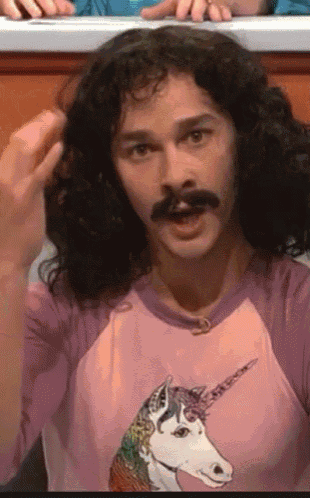

**Что это такое, если по-простому?**
Это область искусственного интеллекта, которая учит компьютеры "видеть" и "понимать" изображения и видео так, как это делаем мы, люди. Ну, или хотя бы стремится к этому. То есть, не просто хранить картинку как набор пикселей, а *извлекать из нее смысл*.

**Где это уже вокруг нас? Да повсюду!**

*   🚗 **Автопилоты в машинах** (Tesla, Waymo): Машины видят дорогу, знаки, другие машины, пешеходов. Это всё CV!
    

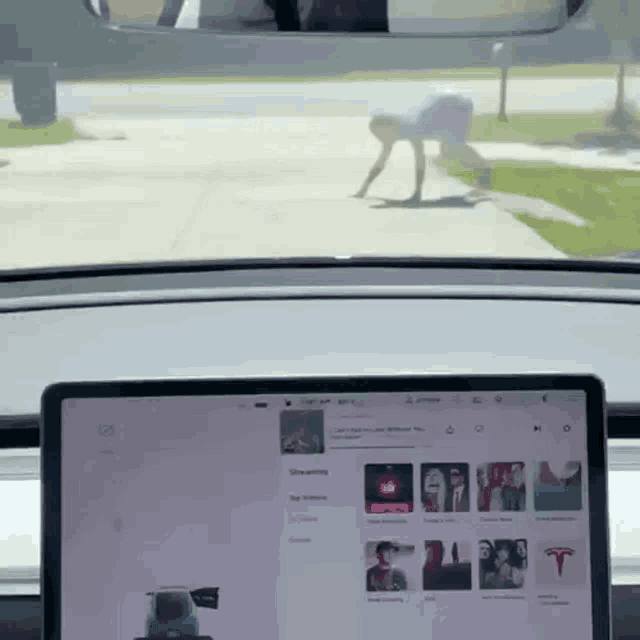

*   📸 **Фильтры в Instagram, Snapchat, TikTok**: Маски, которые идеально ложатся на ваше лицо, эффекты дополненной реальности. Да-да, сначала CV находит ваше лицо, его части (глаза, нос, рот), а потом уже накладывает красоту.
*   🩺 **Медицинская диагностика**: Анализ рентгеновских снимков, МРТ, КТ для поиска опухолей или других патологий. Иногда CV справляется даже лучше человека!
*   🖼️ **Поиск по фото в Google Photos или Яндекс.Картинках**: Вы загружаете фото котика, а поисковик находит похожих котиков. Или вы ищете "закат над морем", и он показывает вам именно такие пейзажи.
*   🔒 **Системы безопасности**: Распознавание лиц для доступа в помещения, отслеживание объектов на камерах видеонаблюдения.
*   🤖 **Робототехника**: Роботы-пылесосы ориентируются в квартире, промышленные роботы берут нужные детали.
*   ... и еще куча всего, от сельского хозяйства (анализ состояния посевов) до спорта (анализ тактики игроков).

**Наш план на сегодня:**
Мы с вами не будем строить Теслу, но попробуем разобраться в основах и сделать свой небольшой, но крутой проект: **систему распознавания лиц в реальном времени!**
То есть, мы научим компьютер:
1.  Находить лица на видео.
2.  "Запоминать" лица (на примере нескольких добровольцев).
3.  И потом узнавать их и подписывать имена прямо на видеопотоке с веб-камеры.

Спойлер: будет немного кода, немного теории, и, надеюсь, много фана! Погнали!

Ячейка для импорта основных библиотек

OpenCV version: 4.11.0
NumPy version: 1.23.3
Face Recognition version: 1.2.3


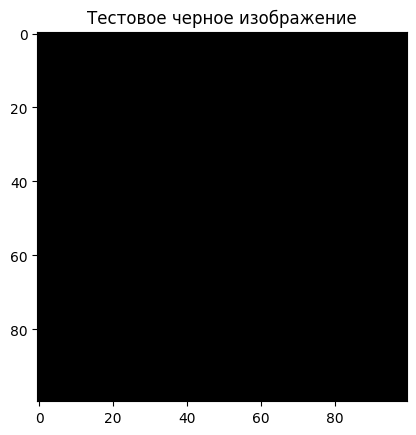

In [1]:
# Проверим, что всё на месте и готово к бою!

import cv2 # Наша главная рабочая лошадка для CV - OpenCV
import numpy as np # Для работы с числовыми массивами (картинки - это они и есть)
import matplotlib.pyplot as plt # Для отображения картинок прямо в Jupyter Notebook
import face_recognition # Супер-библиотека для распознавания лиц, которую мы будем использовать

# Эта строчка нужна, чтобы matplotlib отображал графику прямо в ячейке ноутбука
%matplotlib inline

print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Face Recognition version: {face_recognition.__version__}")

# Небольшая проверка OpenCV - попробуем создать черное изображение
# Это просто для теста, что библиотека работает
test_image = np.zeros((100, 100, 3), dtype="uint8") # 100x100 пикселей, 3 канала (BGR), 8-битное целое
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)) # OpenCV читает в BGR, matplotlib ждет RGB
plt.title("Тестовое черное изображение")
plt.show()

In [4]:
# Обновляем pip до последней версии
!pip install --upgrade pip


In [5]:
# Устанавливаем OpenCV
!pip install opencv-python

In [2]:
# Устанавливаем NumPy (обычно ставится как зависимость OpenCV, но на всякий случай)
!pip install numpy

In [6]:
# Устанавливаем Matplotlib
!pip install matplotlib

In [ ]:
# Устанавливаем face_recognition
# Эта библиотека имеет зависимости, которые могут потребовать сборки: dlib и CMake.
# Сначала установим системные зависимости для dlib:
# sudo apt-get update
# sudo apt-get install -y build-essential cmake
# sudo apt-get install -y libopenblas-dev liblapack-dev # Для оптимизации dlib
# sudo apt-get install -y libx11-dev libgtk-3-dev # Для GUI OpenCV, если понадобится вне Jupyter
# Если python3-dev не установлен (может понадобиться для сборки некоторых пакетов)
# sudo apt-get install -y python3-dev

In [7]:
# Теперь устанавливаем саму библиотеку face_recognition
# Это может занять некоторое время, так как dlib будет компилироваться
!pip install face_recognition

## 1.2. Основы основ: Картинки для машины 🖼️

Итак, чтобы научить машину "видеть", нам сначала нужно понять, а *как* она вообще представляет себе изображение.

**Для компьютера изображение – это просто... матрица чисел!**

*   **Пиксели**: Каждое изображение состоит из ма-а-аленьких точек, называемых пикселями. Каждый пиксель имеет свой цвет.
*   **Разрешение**: Это количество пикселей по ширине и высоте (например, 1920x1080). Чем больше пикселей, тем детальнее картинка.
*   **Цветовые пространства**:
    *   **Grayscale (Оттенки серого)**: Самый простой вариант. Каждый пиксель – это одно число, обычно от 0 (черный) до 255 (белый).
        *   *Представьте себе старую черно-белую фотографию.*
    *   **RGB (Red, Green, Blue)**: Самое популярное для цветных изображений. Каждый пиксель описывается *тремя* числами – интенсивностью красного, зеленого и синего каналов. Каждое из этих чисел тоже обычно от 0 до 255.
        *   *Смешивая эти три основных цвета в разных пропорциях, мы получаем все остальные цвета радуги.*
    *   **BGR**: То же самое, что RGB, но порядок каналов другой: Blue, Green, Red. **Важно:** OpenCV по умолчанию использует именно BGR! Если вы будете показывать картинку в другой библиотеке (например, Matplotlib), которая ожидает RGB, цвета будут искажены, если не сделать конвертацию.
    *   Есть и другие цветовые пространства (HSV, HSL, LAB), но RGB/BGR и Grayscale – наши основные на сегодня.

**Давайте посмотрим на это в коде!**

In [ ]:
# Загрузим какую-нибудь картинку
# Убедитесь, что 'test_image.jpg' (или ваше имя файла) лежит в той же папке, что и ноутбук,
# или укажите полный путь к файлу.
# Я буду использовать встроенную картинку из face_recognition для примера, чтобы код был самодостаточным.

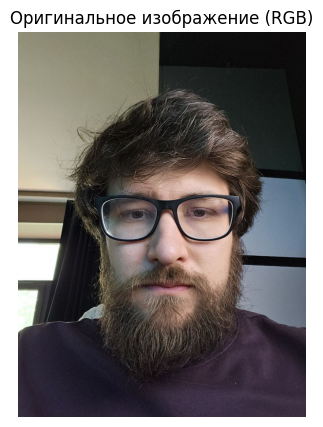

Тип данных изображения: uint8
Форма (размеры) изображения: (1280, 956, 3)


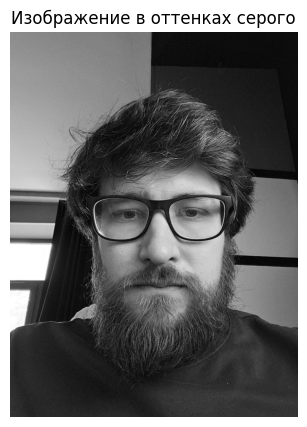

Тип данных grayscale изображения: uint8
Форма (размеры) grayscale изображения: (1280, 956)


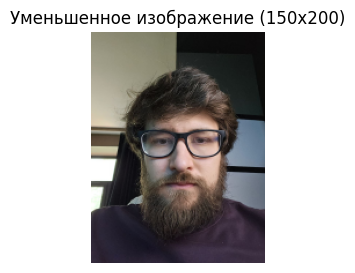

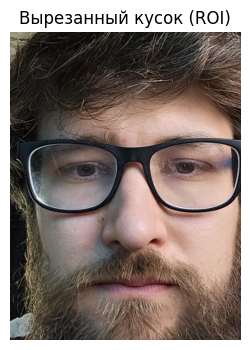

In [2]:
# Укажите путь к вашему изображению
# Предполагается, что Jupyter Notebook запущен из такой директории,
# что этот относительный путь корректен.
# Если нет, используйте абсолютный путь.
your_image_path = "data/d.jpg" # ВАШ ПУТЬ К ФАЙЛУ

try:
    # Загружаем ваше изображение с помощью OpenCV
    # cv2.imread() загружает в BGR формате
    img_bgr = cv2.imread(your_image_path)

    if img_bgr is None:
        raise FileNotFoundError(f"Не удалось загрузить изображение по пути: {your_image_path}. Проверьте путь.")

    # Для единообразия с предыдущими примерами и для matplotlib, получим RGB версию
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Покажем ее с помощью Matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.title("Оригинальное изображение (RGB)")
    plt.axis('off')
    plt.show()

    print(f"Тип данных изображения: {img_rgb.dtype}")
    print(f"Форма (размеры) изображения: {img_rgb.shape}")

except FileNotFoundError as e:
    print(e)
    # Создадим фейковое изображение, чтобы код ниже не падал, если ваше не загрузится
    img_rgb = np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8)
    print("Создано случайное изображение для продолжения демонстрации.")
    plt.imshow(img_rgb)
    plt.title("Случайное изображение (RGB) - ОШИБКА ЗАГРУЗКИ ВАШЕГО ФАЙЛА")
    plt.show()
    # И создадим img_bgr на всякий случай, если он понадобится дальше по коду в этой ячейке
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)


# Конвертируем в оттенки серого
# Для конвертации из RGB в Gray используем cv2.cvtColor
# Если исходник был BGR, то cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) # или cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5,5))
plt.imshow(img_gray, cmap='gray')
plt.title("Изображение в оттенках серого")
plt.axis('off')
plt.show()

print(f"Тип данных grayscale изображения: {img_gray.dtype}")
print(f"Форма (размеры) grayscale изображения: {img_gray.shape}")

# Простые манипуляции
# Ресайз (изменение размера)
if img_rgb is not None and img_rgb.size > 0 : # Проверка, что изображение загружено
    new_width = 150
    ratio = new_width / img_rgb.shape[1]
    new_height = int(img_rgb.shape[0] * ratio)
    resized_img_rgb = cv2.resize(img_rgb, (new_width, new_height), interpolation=cv2.INTER_AREA)

    plt.figure(figsize=(3,3))
    plt.imshow(resized_img_rgb)
    plt.title(f"Уменьшенное изображение ({new_width}x{new_height})")
    plt.axis('off')
    plt.show()

    # Обрезка (Region of Interest - ROI)
    h, w, _ = img_rgb.shape
    roi_rgb = img_rgb[h//4 : 3*h//4, w//4 : 3*w//4]

    plt.figure(figsize=(4,4))
    plt.imshow(roi_rgb)
    plt.title("Вырезанный кусок (ROI)")
    plt.axis('off')
    plt.show()
else:
    print("Пропускаем ресайз и ROI, так как исходное изображение не было загружено.")


## 1.3. Первый шаг к интеллекту: Обнаружение лиц (Face Detection) 🧐

Мы научились загружать картинки и даже немного их "щупать" (смотреть размеры, цвета). Теперь давайте научим компьютер находить на этих картинках что-то осмысленное, а именно – **лица**!

**Что такое Face Detection?**
Это задача, где цель – найти и выделить на изображении или видеокадре области, содержащие человеческие лица. Обычно результатом является набор прямоугольников (bounding boxes), которые очерчивают каждое найденное лицо.

**Важно:** Обнаружение лиц (Face Detection) – это *не то же самое*, что Распознавание лиц (Face Recognition)!
*   **Detection**: "Ага, вот тут есть лицо!"
*   **Recognition**: "Ага, это лицо Васи Пупкина!"
До распознавания мы еще дойдем, а пока сосредоточимся на поиске.

**Как это работает? Краткий обзор подходов:**

1.  **Классика жанра: Каскады Хаара (Viola-Jones Algorithm)**
    *   Это один из первых реально работающих и быстрых методов, предложенный еще в 2001 году. До сих пор популярен для задач, где нужна скорость.
    *   **Идея на пальцах:**
        1.  Используются простые черно-белые шаблончики – **признаки Хаара**. Представьте себе маленькие прямоугольные области: одна светлая, другая темная. Если наложить такой шаблон на область бровей (темные брови, светлый лоб), получится большое значение. Если на щеку (примерно однотонная) – маленькое.
        2.  Таких признаков очень много, разных форм и размеров.
        3.  С помощью алгоритма **AdaBoost** выбираются самые "полезные" признаки и объединяются в "каскад" классификаторов.
        4.  Изображение сканируется окном разного размера. На каждом шаге окно "прогоняется" через каскад. Если все уровни каскада говорят "да, похоже на лицо", то область помечается как лицо. Если хоть один говорит "нет" – идем дальше, это экономит время.
    *   **Плюсы:** Быстро, есть готовые обученные модели в OpenCV.
    *   **Минусы:** Не очень хорошо работает с лицами в профиль, при сильном наклоне, плохом освещении, частичных перекрытиях. Чувствителен к ложным срабатываниям.

    *(Можно показать картинку-пример признаков Хаара)*

2.  **Более продвинутый вариант: HOG + SVM (Histogram of Oriented Gradients + Support Vector Machine)**
    *   **HOG**: Этот метод описывает объект (в нашем случае лицо) через распределение направлений градиентов (насколько резко меняется яркость и куда). Грубо говоря, он смотрит на контуры и формы.
    *   **SVM**: Затем эти "дескрипторы" HOG подаются на вход простому, но эффективному классификатору – машине опорных векторов (SVM), который решает, лицо это или нет.
    *   **Плюсы:** Точнее, чем каскады Хаара, лучше справляется с вариациями освещения. Используется по умолчанию в библиотеке `dlib` (и, соответственно, в `face_recognition` для детекции, если не указан CNN).
    *   **Минусы:** Медленнее, чем каскады Хаара.

3.  **Тяжелая артиллерия: CNN-based детекторы (Convolutional Neural Networks)**
    *   Современные детекторы лиц (например, MTCNN, SSD, YOLO-face) основаны на сверточных нейронных сетях.
    *   **Плюсы:** Самая высокая точность, отлично работают с трудными случаями (разные ракурсы, освещение, перекрытия).
    *   **Минусы:** Требуют значительно больше вычислительных ресурсов (особенно GPU для реального времени), медленнее на CPU по сравнению с классическими методами. `face_recognition` позволяет использовать CNN-модель для детекции.

**Давайте попробуем на практике!**
Сначала используем каскад Хаара из OpenCV, а потом посмотрим на детектор из `face_recognition`.

Каскад Хаара успешно загружен из: /mnt/c/c/ds/env/lib/python3.10/site-packages/cv2/data/haarcascade_frontalface_default.xml
Найдено лиц (Хаар) на 'd.jpg': 11


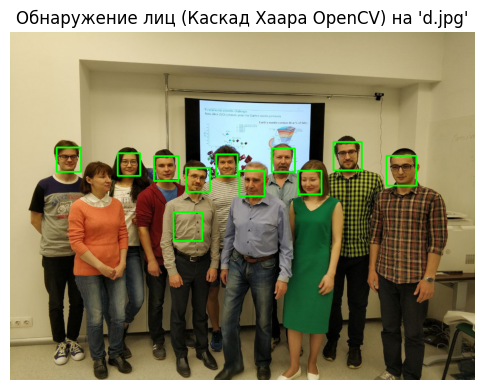

Найдено лиц (face_recognition HOG) на 'd.jpg': 10


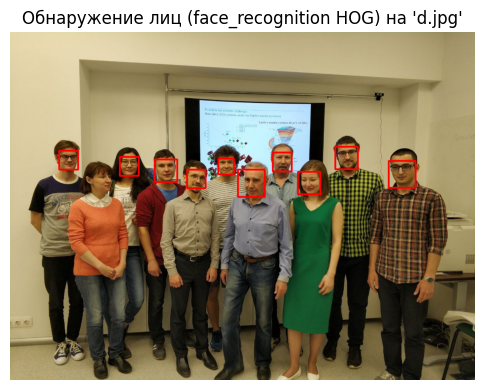

In [3]:
# Укажите путь к вашему основному изображению
your_image_path_d = "data/d3.jpg" # ВАШ ПУТЬ К ФАЙЛУ d.jpg

# (Опционально) Укажите путь к изображению с несколькими лицами, если есть
# Если нет, оставим пустым или None, и будем использовать ваше одиночное фото
your_multi_face_image_path = None # или "путь/к/вашему/фото_с_несколькими_лицами.jpg"

try:
    # Загружаем ваше изображение (d.jpg)
    img_bgr_d = cv2.imread(your_image_path_d)
    if img_bgr_d is None:
        raise FileNotFoundError(f"Не удалось загрузить изображение: {your_image_path_d}")
    img_rgb_d = cv2.cvtColor(img_bgr_d, cv2.COLOR_BGR2RGB)
    img_gray_d = cv2.cvtColor(img_bgr_d, cv2.COLOR_BGR2GRAY) # Для каскада Хаара

except FileNotFoundError as e:
    print(e)
    # Заглушка, если не удалось загрузить
    img_rgb_d = np.random.randint(0, 256, (400, 300, 3), dtype=np.uint8)
    img_gray_d = cv2.cvtColor(img_rgb_d, cv2.COLOR_RGB2GRAY)
    print("Создано случайное изображение (d.jpg) для продолжения демонстрации.")


# --- Обнаружение лиц с помощью Каскада Хаара (OpenCV) ---
haar_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
import os
if not os.path.exists(haar_cascade_path):
    print(f"Ошибка: Не найден файл каскада Хаара по пути: {haar_cascade_path}")
    haar_cascade_path = None # Чтобы код ниже не падал, а выводил сообщение

if haar_cascade_path:
    face_cascade = cv2.CascadeClassifier(haar_cascade_path)
    if face_cascade.empty():
        print("Ошибка: Не удалось загрузить каскад Хаара. Проверьте путь.")
    else:
        print(f"Каскад Хаара успешно загружен из: {haar_cascade_path}")
        faces_haar = face_cascade.detectMultiScale(img_gray_d, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        print(f"Найдено лиц (Хаар) на 'd.jpg': {len(faces_haar)}")

        img_with_rects_haar = img_rgb_d.copy()
        for (x, y, w, h) in faces_haar:
            cv2.rectangle(img_with_rects_haar, (x, y), (x+w, y+h), (0, 255, 0), 3)

        plt.figure(figsize=(6,6))
        plt.imshow(img_with_rects_haar)
        plt.title("Обнаружение лиц (Каскад Хаара OpenCV) на 'd.jpg'")
        plt.axis('off')
        plt.show()
else:
    print("Пропускаем детекцию Хаара, так как каскад не найден.")


# --- Обнаружение лиц с помощью face_recognition (HOG по умолчанию) ---
# Загружаем изображение для face_recognition (оно должно быть RGB)
# Будем использовать img_rgb_d (ваше фото d.jpg)
# Если у вас есть отдельное фото с несколькими лицами, загрузим его:
if your_multi_face_image_path:
    try:
        img_multi_bgr = cv2.imread(your_multi_face_image_path)
        if img_multi_bgr is None: raise FileNotFoundError
        img_multi_rgb_fr = cv2.cvtColor(img_multi_bgr, cv2.COLOR_BGR2RGB)
        image_for_fr_detection = img_multi_rgb_fr
        fr_title_suffix = "на 'multi-face image'"
    except FileNotFoundError:
        print(f"Файл '{your_multi_face_image_path}' не найден, используем 'd.jpg' для face_recognition.")
        image_for_fr_detection = img_rgb_d
        fr_title_suffix = "на 'd.jpg'"
else:
    image_for_fr_detection = img_rgb_d
    fr_title_suffix = "на 'd.jpg'"


if image_for_fr_detection.size > 0: # Проверка, что изображение загружено
    face_locations_hog = face_recognition.face_locations(image_for_fr_detection, model="hog")
    print(f"Найдено лиц (face_recognition HOG) {fr_title_suffix}: {len(face_locations_hog)}")

    img_with_rects_fr_hog = image_for_fr_detection.copy()
    for (top, right, bottom, left) in face_locations_hog:
        cv2.rectangle(img_with_rects_fr_hog, (left, top), (right, bottom), (255, 0, 0), 3)

    plt.figure(figsize=(6,6))
    plt.imshow(img_with_rects_fr_hog)
    plt.title(f"Обнаружение лиц (face_recognition HOG) {fr_title_suffix}")
    plt.axis('off')
    plt.show()
else:
    print("Пропускаем детекцию face_recognition, так как изображение не загружено.")



Запускаем CNN детектор лиц (может быть медленно)...
Найдено лиц (face_recognition CNN) на 'd.jpg': 11


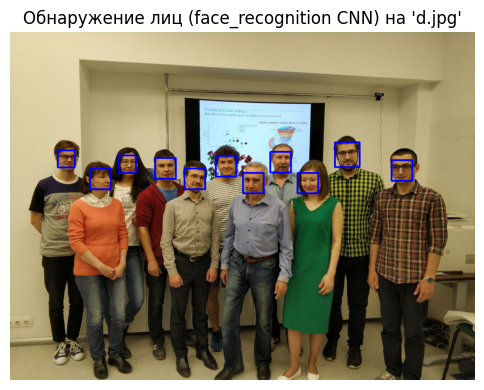

In [4]:
print("\nЗапускаем CNN детектор лиц (может быть медленно)...")
if image_for_fr_detection.size > 0:
    face_locations_cnn = face_recognition.face_locations(image_for_fr_detection, model="cnn")
    print(f"Найдено лиц (face_recognition CNN) {fr_title_suffix}: {len(face_locations_cnn)}")

    img_with_rects_fr_cnn = image_for_fr_detection.copy()
    for (top, right, bottom, left) in face_locations_cnn:
        cv2.rectangle(img_with_rects_fr_cnn, (left, top), (right, bottom), (0, 0, 255), 3)

    plt.figure(figsize=(6,6))
    plt.imshow(img_with_rects_fr_cnn)
    plt.title(f"Обнаружение лиц (face_recognition CNN) {fr_title_suffix}")
    plt.axis('off')
    plt.show()
else:
    print("Пропускаем CNN детекцию, изображение не загружено.")

# Часть 2: От Лица к Личности: Магия Распознавания 

Итак, мы научились довольно неплохо находить лица на фотографиях. Наш компьютер теперь может сказать: "Здесь лицо, и вот здесь тоже лицо!". Но этого мало. Мы хотим, чтобы он сказал: "А вот это – ты, дорогой препод, а это – студентка Маша, а это – студент Петя!"

Это и есть задача **Распознавания Лиц (Face Recognition)**.

**В чем ключевое отличие от Детекции?**
*   **Детекция (Detection)**: Просто найти *факт наличия* лица и его границы.
*   **Распознавание (Recognition)**: Определить *идентичность* человека, которому принадлежит найденное лицо. Это всегда включает в себя этап детекции.

**Почему нельзя просто сравнить пиксели вырезанных лиц?**
Казалось бы, нашли лицо, вырезали его – теперь можно просто сравнить этот "кусочек" с другими "кусочками" из нашей базы известных людей. Но нет, так не работает (или работает очень плохо). Почему?
*   **Освещение**: Лицо может быть освещено с разных сторон, быть в тени – пиксельные значения сильно изменятся.
*   **Мимика**: Улыбка, удивление, грусть – всё это меняет вид лица.
*   **Ракурс**: Небольшой поворот головы, наклон – и пиксели уже совсем другие.
*   **Возраст, прическа, очки, макияж, борода**: Всё это тоже сильно влияет на "сырые" пиксели.

Нам нужен способ описать лицо так, чтобы это описание было:
1.  **Уникальным** для каждого человека (или достаточно уникальным).
2.  **Устойчивым** (инвариантным) ко всем этим изменениям (освещение, мимика, ракурс и т.д.).

**Идея! "Цифровой отпечаток" лица – Face Embedding**
Решение пришло с развитием глубокого обучения. Идея в том, чтобы с помощью специально обученной нейронной сети преобразовать изображение лица в некоторый **вектор чисел** фиксированной длины (например, 128 чисел). Этот вектор и называется **Face Embedding** (внедрение лица, кодировка лица, вектор признаков лица).



**Свойства "хорошего" Face Embedding:**
*   Эмбеддинги **одного и того же человека** (даже с разных фото, при разном освещении, с разной мимикой) должны быть **очень близки** друг к другу в этом векторном пространстве (малое расстояние между векторами).
*   Эмбеддинги **разных людей** должны быть **далеко** друг от друга (большое расстояние).

**Как обучают такие нейросети?**
Обычно используются специальные архитектуры (например, Siamese Networks) и функции потерь (например, Triplet Loss).
*   **Triplet Loss (на пальцах):** Сети показывают три картинки:
    1.  "Якорь" (Anchor): Фото человека А.
    2.  "Позитив" (Positive): Другое фото человека А.
    3.  "Негатив" (Negative): Фото человека Б.
    И сеть штрафуют, если расстояние (Якорь, Позитив) оказывается больше, чем расстояние (Якорь, Негатив), или если они слишком близки. Таким образом, сеть учится "сжимать" пространство для одного человека и "расталкивать" пространства для разных.

Известные модели, которые генерируют эмбеддинги: FaceNet (Google), VGGFace/VGGFace2 (Oxford), ArcFace, CosFace и другие. Они обучены на ОГРОМНЫХ датасетах с миллионами лиц и личностей.

**Хорошая новость:** Нам не нужно обучать эти гигантские сети с нуля! Мы будем использовать уже **предобученную модель** из библиотеки `face_recognition`. Под капотом там, скорее всего, работает модель, основанная на архитектуре ResNet (Residual Network), обученная в `dlib` на большом наборе лиц для генерации как раз таких 128-мерных эмбеддингов.

**Принцип распознавания с эмбеддингами:**
1.  **Регистрация (Enrollment):**
    *   Берем одно или несколько фото известного нам человека (например, мое фото `d.jpg`).
    *   Находим на нем лицо.
    *   Прогоняем это лицо через нашу предобученную нейросеть и получаем его эмбеддинг (вектор из 128 чисел).
    *   Сохраняем этот эмбеддинг вместе с именем человека в нашу "базу знаний".
2.  **Распознавание (Recognition):**
    *   Берем новое (неизвестное) фото или кадр с видео.
    *   Находим на нем лицо.
    *   Получаем его эмбеддинг.
    *   **Сравниваем** этот новый эмбеддинг со всеми эмбеддингами из нашей "базы знаний". Сравнение – это обычно вычисление расстояния (например, Евклидова) или косинусного сходства между векторами.
    *   Если расстояние до какого-то эмбеддинга из базы достаточно мало (меньше определенного порога), мы считаем, что это тот самый человек.

Звучит логично? Давайте посмотрим, какие инструменты для этого есть в `face_recognition`.

## 2.2. Библиотека `face_recognition`: Наш швейцарский нож 🛠️

Библиотека `face_recognition` – это очень удобная штука, построенная поверх `dlib`. Она предоставляет простой API для самых частых задач с лицами. Мы уже использовали `face_locations()` для детекции. Теперь посмотрим на другие её полезные функции:

*   `face_recognition.face_encodings(image, known_face_locations=None, num_jitters=1, model="small")`:
    *   Принимает на вход изображение (в виде NumPy array, ожидается RGB) и опционально координаты уже найденных лиц (`known_face_locations`). Если координаты не переданы, она сначала сама найдет лица (используя HOG по умолчанию).
    *   Возвращает список 128-мерных эмбеддингов (кодировок) для каждого найденного лица.
    *   `num_jitters`: Сколько раз "дрогнуть" изображением перед кодированием. Больше = потенциально лучше качество, но медленнее. Для начала 1 достаточно.
    *   `model`: "small" (по умолчанию, быстрее) или "large" (потенциально точнее, но медленнее).

*   `face_recognition.compare_faces(known_face_encodings, face_encoding_to_check, tolerance=0.6)`:
    *   Принимает список известных эмбеддингов (`known_face_encodings`) и один эмбеддинг для проверки (`face_encoding_to_check`).
    *   Возвращает список булевых значений (`True`/`False`) – по одному для каждого известного эмбеддинга. `True` означает, что проверяемый эмбеддинг "похож" на соответствующий известный (расстояние меньше `tolerance`).
    *   `tolerance`: Порог для принятия решения. Чем меньше значение, тем строже сравнение. Значение по умолчанию 0.6 – это хороший старт. Если у вас много ложных срабатываний, можно уменьшить (например, 0.55). Если много пропусков знакомых лиц – можно немного увеличить (например, 0.65), но осторожно.

*   `face_recognition.face_distance(face_encodings, face_to_compare)`:
    *   Вычисляет Евклидово расстояние между списком эмбеддингов и одним эмбеддингом.
    *   Возвращает NumPy массив расстояний. Чем меньше расстояние, тем "похожее" лица.
    *   Это полезно, чтобы не просто получить `True`/`False`, а увидеть *насколько* лица похожи, и, например, выбрать самое похожее из нескольких кандидатов.

**Давайте это всё опробуем!**
Мы загрузим ваше фото (`d.jpg`) и одно из групповых (`d2.jpg`). Получим эмбеддинги для всех лиц и попробуем "узнать" вас на групповом фото.

Получен эмбеддинг для вашего лица с фото 'data/d.jpg'

Ищем лица на групповом фото 'data/d2.jpg' (модель CNN, может занять время)...
Найдено 5 лиц на групповом фото.
Получено 5 эмбеддингов с группового фото.
Лицо #1 на групповом фото: НЕТ совпадения. Расстояние: 0.66
Лицо #2 на групповом фото: СОВПАДЕНИЕ! Расстояние: 0.48
Лицо #3 на групповом фото: НЕТ совпадения. Расстояние: 0.80
Лицо #4 на групповом фото: НЕТ совпадения. Расстояние: 0.75
Лицо #5 на групповом фото: НЕТ совпадения. Расстояние: 0.77

Отлично, вы были найдены!


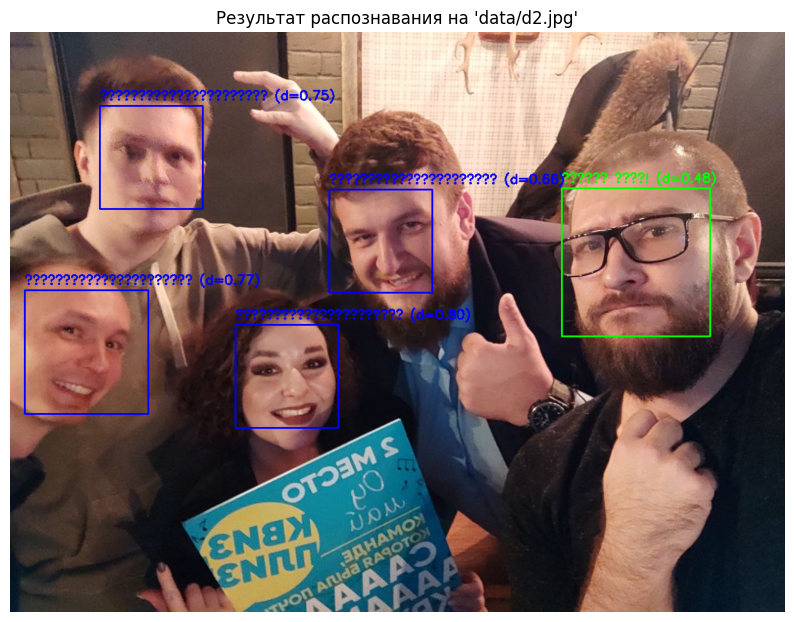

In [28]:
# --- Получение и сравнение Face Embeddings ---

# Пути к вашим файлам
your_face_path = "data/d.jpg"  # Ваше одиночное фото
group_photo_path = "data/d2.jpg" # Ваше групповое фото

try:
    # 1. Загружаем ваше эталонное изображение (одно лицо)
    your_image_bgr = cv2.imread(your_face_path)
    if your_image_bgr is None:
        raise FileNotFoundError(f"Эталонное фото не найдено: {your_face_path}")
    your_image_rgb = cv2.cvtColor(your_image_bgr, cv2.COLOR_BGR2RGB)

    # 2. Находим лицо на вашем эталонном фото и получаем его эмбеддинг
    #    Мы предполагаем, что на d.jpg только одно ваше лицо и оно хорошо видно.
    #    face_locations вернет список, даже если лицо одно.
    your_face_locations = face_recognition.face_locations(your_image_rgb, model="hog") # Можно "cnn" если на d.jpg сложное лицо
    if not your_face_locations:
        raise ValueError(f"Лицо не найдено на эталонном фото: {your_face_path}. Убедитесь, что лицо видно четко.")

    # Получаем эмбеддинг (кодировку) вашего лица. Берем первый найденный (предполагаем, он один)
    your_face_encoding = face_recognition.face_encodings(your_image_rgb, known_face_locations=your_face_locations)[0]
    # print("Эмбеддинг вашего лица (первые 10 из 128 значений):", your_face_encoding[:10])
    print(f"Получен эмбеддинг для вашего лица с фото '{your_face_path}'")

    # 3. Загружаем групповое фото
    group_image_bgr = cv2.imread(group_photo_path)
    if group_image_bgr is None:
        raise FileNotFoundError(f"Групповое фото не найдено: {group_photo_path}")
    group_image_rgb = cv2.cvtColor(group_image_bgr, cv2.COLOR_BGR2RGB)

    # 4. Находим все лица на групповом фото
    #    Используем CNN, так как вы сказали, он лучше работает на ваших групповых фото
    print(f"\nИщем лица на групповом фото '{group_photo_path}' (модель CNN, может занять время)...")
    group_face_locations = face_recognition.face_locations(group_image_rgb, model="cnn") # или "hog", если CNN слишком долго
    print(f"Найдено {len(group_face_locations)} лиц на групповом фото.")

    if not group_face_locations:
        print("На групповом фото лица не найдены. Демонстрация сравнения невозможна.")
    else:
        # 5. Получаем эмбеддинги для всех найденных лиц на групповом фото
        group_face_encodings = face_recognition.face_encodings(group_image_rgb, known_face_locations=group_face_locations)
        print(f"Получено {len(group_face_encodings)} эмбеддингов с группового фото.")

        # 6. Теперь сравниваем ваше эталонное лицо с каждым лицом на групповом фото
        img_to_draw_on = group_image_rgb.copy()
        found_you = False

        for i, unknown_face_encoding in enumerate(group_face_encodings):
            # Сравниваем ваше эталонное лицо (известное) с текущим неизвестным лицом
            # compare_faces вернет [True] если совпало, или [False] если нет,
            # т.к. known_face_encodings у нас это список из одного вашего эмбеддинга.
            matches = face_recognition.compare_faces([your_face_encoding], unknown_face_encoding, tolerance=0.55) # Попробуйте 0.5, 0.55 или 0.6
            
            # face_distance дает численное значение "похожести"
            # Чем меньше, тем больше похожи.
            distance = face_recognition.face_distance([your_face_encoding], unknown_face_encoding)[0]

            name = "Неизвестный"
            color = (0, 0, 255) # Красный для неизвестных

            if matches[0]: # Если есть совпадение
                name = "Это ВЫ!" # Или ваше имя
                color = (0, 255, 0) # Зеленый для вас
                found_you = True
                print(f"Лицо #{i+1} на групповом фото: СОВПАДЕНИЕ! Расстояние: {distance:.2f}")
            else:
                print(f"Лицо #{i+1} на групповом фото: НЕТ совпадения. Расстояние: {distance:.2f}")

            # Получаем координаты лица на групповом фото для рисования
            top, right, bottom, left = group_face_locations[i]
            cv2.rectangle(img_to_draw_on, (left, top), (right, bottom), color, 2)
            cv2.putText(img_to_draw_on, f"{name} (d={distance:.2f})", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        if not found_you and len(group_face_locations) > 0:
            print("\nК сожалению, вы не были найдены на групповом фото с текущим порогом.")
            print("Попробуйте изменить значение 'tolerance' в face_recognition.compare_faces().")
            print("Например, если расстояния до 'неизвестных' были близки к 0.6, можно попробовать tolerance=0.6 или 0.62.")
        elif len(group_face_locations) > 0 :
             print("\nОтлично, вы были найдены!")


        plt.figure(figsize=(10,10))
        plt.imshow(img_to_draw_on)
        plt.title(f"Результат распознавания на '{group_photo_path}'")
        plt.axis('off')
        plt.show()

except FileNotFoundError as e:
    print(f"Ошибка файла: {e}")
except ValueError as e:
    print(f"Ошибка значения: {e}")
except Exception as e:
    print(f"Произошла непредвиденная ошибка: {e}")

Получен эмбеддинг для вашего лица с фото 'data/d.jpg'

Ищем лица на групповом фото 'data/d3.jpg' (модель CNN, может занять время)...
Найдено 11 лиц на групповом фото.
Получено 11 эмбеддингов с группового фото.
Лицо #1 на групповом фото: НЕТ совпадения. Расстояние: 0.78
Лицо #2 на групповом фото: НЕТ совпадения. Расстояние: 0.86
Лицо #3 на групповом фото: СОВПАДЕНИЕ! Расстояние: 0.53
Лицо #4 на групповом фото: НЕТ совпадения. Расстояние: 0.75
Лицо #5 на групповом фото: НЕТ совпадения. Расстояние: 0.79
Лицо #6 на групповом фото: НЕТ совпадения. Расстояние: 0.79
Лицо #7 на групповом фото: НЕТ совпадения. Расстояние: 0.78
Лицо #8 на групповом фото: НЕТ совпадения. Расстояние: 0.81
Лицо #9 на групповом фото: НЕТ совпадения. Расстояние: 0.81
Лицо #10 на групповом фото: НЕТ совпадения. Расстояние: 0.74
Лицо #11 на групповом фото: НЕТ совпадения. Расстояние: 0.78

Отлично, вы были найдены!


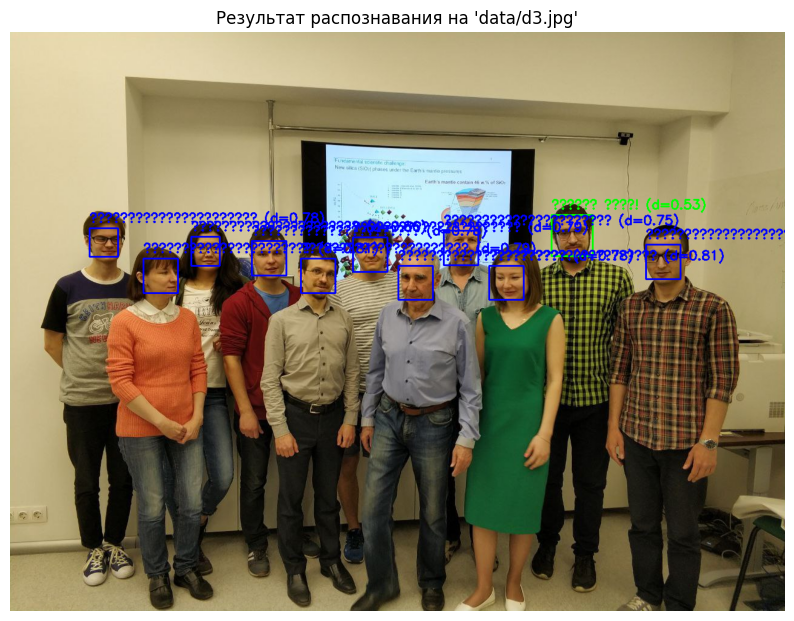

In [27]:
# --- Получение и сравнение Face Embeddings ---

# Пути к вашим файлам
your_face_path = "data/d.jpg"  # Ваше одиночное фото
group_photo_path = "data/d3.jpg" # Ваше групповое фото

try:
    # 1. Загружаем ваше эталонное изображение (одно лицо)
    your_image_bgr = cv2.imread(your_face_path)
    if your_image_bgr is None:
        raise FileNotFoundError(f"Эталонное фото не найдено: {your_face_path}")
    your_image_rgb = cv2.cvtColor(your_image_bgr, cv2.COLOR_BGR2RGB)

    # 2. Находим лицо на вашем эталонном фото и получаем его эмбеддинг
    #    Мы предполагаем, что на d.jpg только одно ваше лицо и оно хорошо видно.
    #    face_locations вернет список, даже если лицо одно.
    your_face_locations = face_recognition.face_locations(your_image_rgb, model="hog") # Можно "cnn" если на d.jpg сложное лицо
    if not your_face_locations:
        raise ValueError(f"Лицо не найдено на эталонном фото: {your_face_path}. Убедитесь, что лицо видно четко.")

    # Получаем эмбеддинг (кодировку) вашего лица. Берем первый найденный (предполагаем, он один)
    your_face_encoding = face_recognition.face_encodings(your_image_rgb, known_face_locations=your_face_locations)[0]
    # print("Эмбеддинг вашего лица (первые 10 из 128 значений):", your_face_encoding[:10])
    print(f"Получен эмбеддинг для вашего лица с фото '{your_face_path}'")

    # 3. Загружаем групповое фото
    group_image_bgr = cv2.imread(group_photo_path)
    if group_image_bgr is None:
        raise FileNotFoundError(f"Групповое фото не найдено: {group_photo_path}")
    group_image_rgb = cv2.cvtColor(group_image_bgr, cv2.COLOR_BGR2RGB)

    # 4. Находим все лица на групповом фото
    #    Используем CNN, так как вы сказали, он лучше работает на ваших групповых фото
    print(f"\nИщем лица на групповом фото '{group_photo_path}' (модель CNN, может занять время)...")
    group_face_locations = face_recognition.face_locations(group_image_rgb, model="cnn") # или "hog", если CNN слишком долго
    print(f"Найдено {len(group_face_locations)} лиц на групповом фото.")

    if not group_face_locations:
        print("На групповом фото лица не найдены. Демонстрация сравнения невозможна.")
    else:
        # 5. Получаем эмбеддинги для всех найденных лиц на групповом фото
        group_face_encodings = face_recognition.face_encodings(group_image_rgb, known_face_locations=group_face_locations)
        print(f"Получено {len(group_face_encodings)} эмбеддингов с группового фото.")

        # 6. Теперь сравниваем ваше эталонное лицо с каждым лицом на групповом фото
        img_to_draw_on = group_image_rgb.copy()
        found_you = False

        for i, unknown_face_encoding in enumerate(group_face_encodings):
            # Сравниваем ваше эталонное лицо (известное) с текущим неизвестным лицом
            # compare_faces вернет [True] если совпало, или [False] если нет,
            # т.к. known_face_encodings у нас это список из одного вашего эмбеддинга.
            matches = face_recognition.compare_faces([your_face_encoding], unknown_face_encoding, tolerance=0.55) # Попробуйте 0.5, 0.55 или 0.6
            
            # face_distance дает численное значение "похожести"
            # Чем меньше, тем больше похожи.
            distance = face_recognition.face_distance([your_face_encoding], unknown_face_encoding)[0]

            name = "Неизвестный"
            color = (0, 0, 255) # Красный для неизвестных

            if matches[0]: # Если есть совпадение
                name = "Это ВЫ!" # Или ваше имя
                color = (0, 255, 0) # Зеленый для вас
                found_you = True
                print(f"Лицо #{i+1} на групповом фото: СОВПАДЕНИЕ! Расстояние: {distance:.2f}")
            else:
                print(f"Лицо #{i+1} на групповом фото: НЕТ совпадения. Расстояние: {distance:.2f}")

            # Получаем координаты лица на групповом фото для рисования
            top, right, bottom, left = group_face_locations[i]
            cv2.rectangle(img_to_draw_on, (left, top), (right, bottom), color, 2)
            cv2.putText(img_to_draw_on, f"{name} (d={distance:.2f})", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        if not found_you and len(group_face_locations) > 0:
            print("\nК сожалению, вы не были найдены на групповом фото с текущим порогом.")
            print("Попробуйте изменить значение 'tolerance' в face_recognition.compare_faces().")
            print("Например, если расстояния до 'неизвестных' были близки к 0.6, можно попробовать tolerance=0.6 или 0.62.")
        elif len(group_face_locations) > 0 :
             print("\nОтлично, вы были найдены!")


        plt.figure(figsize=(10,10))
        plt.imshow(img_to_draw_on)
        plt.title(f"Результат распознавания на '{group_photo_path}'")
        plt.axis('off')
        plt.show()

except FileNotFoundError as e:
    print(f"Ошибка файла: {e}")
except ValueError as e:
    print(f"Ошибка значения: {e}")
except Exception as e:
    print(f"Произошла непредвиденная ошибка: {e}")

**Что мы только что сделали?**

1.  Загрузили ваше "эталонное" фото (`d.jpg`), нашли на нем ваше лицо и получили его 128-мерный "цифровой отпечаток" (`your_face_encoding`).
2.  Загрузили групповое фото (`d2.jpg`).
3.  Нашли *все* лица на групповом фото и для каждого получили свой эмбеддинг. CNN лучше работает, так что мы использовали `model="cnn"` для детекции на групповом фото. Это может занять некоторое время!
4.  Затем мы взяли ваш эталонный эмбеддинг и поочередно сравнили его с каждым эмбеддингом с группового фото с помощью `face_recognition.compare_faces()`.
5.  Также мы вывели `face_distance()` – это численное значение "расстояния". Чем оно меньше, тем больше лица похожи. Порог `tolerance` (я поставил 0.55 для примера, стандартно 0.6) как раз и решает, достаточно ли это расстояние мало, чтобы считать лица принадлежащими одному человеку.
6.  Нарисовали результат на картинке.

**Поиграйтесь с `tolerance`!**
Если вас не нашло, а расстояние было, скажем, 0.58, а `tolerance` был 0.55 – попробуйте увеличить `tolerance` до 0.6. Если же нашлось чужое лицо как ваше, значит, `tolerance` слишком большой, и его надо уменьшить. Это ключевой параметр для настройки точности.

Теперь, когда мы понимаем, как получать эмбеддинги и сравнивать их для двух картинок, мы почти готовы к созданию нашей интерактивной системы, которая будет делать это в реальном времени с веб-камерой!

## 2.3. Подготовка к живому демо: Логика нашей системы 🧠

Итак, мы умеем:
1.  Находить лица на фото (`face_locations`).
2.  Получать их "цифровые отпечатки" – эмбеддинги (`face_encodings`).
3.  Сравнивать эмбеддинги и определять, принадлежат ли они одному человеку (`compare_faces`, `face_distance`).

Теперь наша задача – собрать всё это вместе в интерактивную систему, которая будет работать с видеопотоком с веб-камеры.

**Какую систему мы хотим построить?**

Представьте себе программу, у которой есть два основных режима работы:

1.  **Режим "Регистрации" (Enrollment / "Запомнить меня")**:
    *   студент-доброволец подходит к веб-камере.
    *   я жмякую специальную клавишу (например, **'s'** – от *save*).
    *   Программа:
        *   Захватывает текущий кадр с веб-камеры.
        *   Находит на нем лицо (будем надеяться, что лицо одно и хорошо видно).
        *   Получает эмбеддинг этого лица.
        *   Спрашивает у нас (лектора) имя этого человека (мы вводим его с клавиатуры прямо в консоль или в поле ввода Jupyter, если бы мы делали GUI).
        *   Сохраняет этот эмбеддинг и введенное имя в нашу "базу знаний". База знаний будет просто двумя списками в памяти: один для эмбеддингов, другой для соответствующих имен.
    *   Программа сообщает: "Человек [Имя] зарегистрирован!"

2.  **Режим "Распознавания" (Recognition / "Узнавание")**:
    *   Это основной режим работы программы, когда она просто показывает видео с веб-камеры.
    *   На каждом кадре видео программа:
        *   Находит *все* лица, которые видит.
        *   Для *каждого* найденного лица получает его эмбеддинг.
        *   Сравнивает этот эмбеддинг со *всеми* эмбеддингами из нашей "базы знаний" (которую мы наполнили в режиме регистрации).
        *   Если находится совпадение (расстояние до известного эмбеддинга меньше нашего `tolerance`):
            *   Программа подписывает на видео имя соответствующего человека.
        *   Если совпадений нет:
            *   Программа подписывает "Неизвестный".
    *   Обработанный кадр (с нарисованными прямоугольниками и именами) отображается на экране.

**Как будет выглядеть наша "база знаний"?**
Очень просто! Два Python-списка:
*   `known_face_encodings = []` # Сюда будем добавлять 128-мерные векторы (эмбеддинги)
*   `known_face_names = []`    # Сюда – соответствующие имена (строки)

Когда мы регистрируем нового человека, мы добавляем его эмбеддинг в первый список и его имя – во второй. Важно, чтобы порядок соответствовал!

**Псевдокод/Логика работы основного цикла программы:**

**Ключевые моменты для реализации в коде (заготовки):**

*   **Захват видео с веб-камеры:** `cv2.VideoCapture(0)`
*   **Чтение кадра:** `cap.read()`
*   **Отображение кадра:** `cv2.imshow('Video', frame)`
*   **Обработка нажатий клавиш:** `key = cv2.waitKey(1) & 0xFF`
    *   `if key == ord('s'):`
    *   `if key == ord('q'):`
*   **Ввод имени пользователя:** `name = input("Введите имя регистрируемого человека: ")` (будет работать в консоли, где запущен Jupyter сервер, или прямо под ячейкой, если запускать скрипт из ячейки, который делает `input()`).
*   Остальные функции (`face_locations`, `face_encodings`, `compare_faces`, `face_distance`, `cv2.rectangle`, `cv2.putText`) мы уже знаем.


Ну что, теория и планирование закончены! В следующей части – кульминация: пишем код и запускаем нашу систему! 

In [8]:
import cv2

cap = cv2.VideoCapture(0) # 0 - это обычно встроенная веб-камера

if not cap.isOpened():
    print("Ошибка: Не могу получить доступ к веб-камере.")
else:
    print("Веб-камера найдена. Нажмите 'q' в окне видео, чтобы закрыть.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Ошибка: Не могу получить кадр с камеры.")
            break

        cv2.imshow('Тест Веб-камеры', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    # Важно! В Jupyter иногда окна не закрываются сами после destroyAllWindows()
    # если ядро продолжает работать. Может потребоваться перезапуск ядра или ручное закрытие.
    # Для корректной работы с cv2.destroyAllWindows() лучше всего запускать код как отдельный .py скрипт.
    # В Jupyter может помочь вызов cv2.waitKey(1) несколько раз после destroyAllWindows()
    for i in range(5): # Небольшой хак для Jupyter, чтобы окна успели обработать закрытие
        cv2.waitKey(1)

Ошибка: Не могу получить доступ к веб-камере.


[ WARN:0@44.473] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@44.473] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


По умолчанию WSL2 не имеет прямого доступа к USB-устройствам, подключенным к хостовой системе Windows, включая многие веб-камеры (особенно внешние USB-камеры). Встроенные камеры иногда работают "из коробки", но не всегда.